# Dog Breeds Image Classification

In this notebook, we will use [dog breed images](http://vision.stanford.edu/aditya86/ImageNetDogs/) and use transfer learning to identify the dog breed. The hyperparameter tuning and model training are done using Sagemaker training job.

In [19]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
INSTALL_PACKAGES = False
if INSTALL_PACKAGES:
    !pip install smdebug
    !pip install tqdm

In [20]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import numpy as np

BUCKET = 'project03-image-classification-vexenta'

## Dataset

*TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.*

The dataset contains images of 133 dog breeds, which are already split into train, validation, and test sets.

In [21]:
#TODO: Fetch and upload the data to AWS S3
DOWNLOAD_DATASET = False
if DOWNLOAD_DATASET:
    # Command to download and unzip data
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    
UPLOAD_TO_S3 = False
os.environ["DEFAULT_S3_BUCKET"] = BUCKET

if UPLOAD_TO_S3:
    !aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
    !aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
    !aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

There are 133 dog breeds; each dog breed image is stored in a directory. There are at least 20 images per breed.

In [22]:
## ensure the files are successfully uploaded
CHECK_UPLOAD = True
if CHECK_UPLOAD:
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/  | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/valid/ | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/test/ | wc -l
        
    ## preview of the breeds
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/ | tail -n 10

133
133
133
                           PRE 124.Poodle/
                           PRE 125.Portuguese_water_dog/
                           PRE 126.Saint_bernard/
                           PRE 127.Silky_terrier/
                           PRE 128.Smooth_fox_terrier/
                           PRE 129.Tibetan_mastiff/
                           PRE 130.Welsh_springer_spaniel/
                           PRE 131.Wirehaired_pointing_griffon/
                           PRE 132.Xoloitzcuintli/
                           PRE 133.Yorkshire_terrier/


### Dataset Preview

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_image(image_file_directory: str = None, image_file_path: str = None):
    if image_file_path is None:
        assert image_file_directory is not None, "image_file_directory must be specified if image_file_path is None!"
        image_file_name_list = os.listdir(image_file_directory)
        selected_image_index = np.random.choice(len(image_file_name_list))
        selected_image_file_name = image_file_name_list[selected_image_index]
        image_file_path = os.path.join(
            image_file_directory,
            selected_image_file_name
        )
    else:
        selected_image_file_name = image_file_path.split("/")[-1]
    
    img = mpimg.imread(image_file_path)
    img_plot = plt.imshow(img)
    plt.title(selected_image_file_name)
    plt.show()

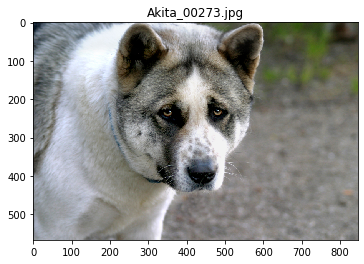

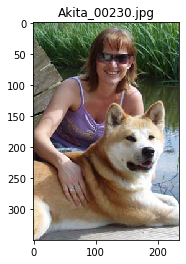

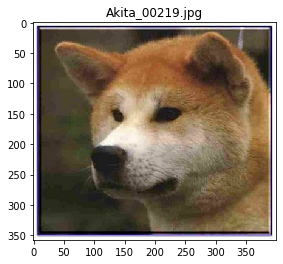

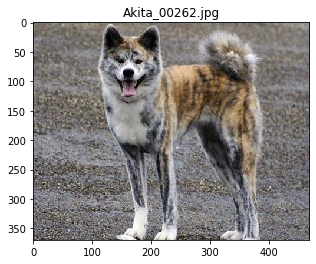

In [24]:
show_image(image_file_directory="dogImages/train/004.Akita")
show_image(image_file_path="dogImages/train/004.Akita/Akita_00230.jpg")

show_image(image_file_directory="dogImages/valid/004.Akita")
show_image(image_file_directory="dogImages/test/004.Akita")

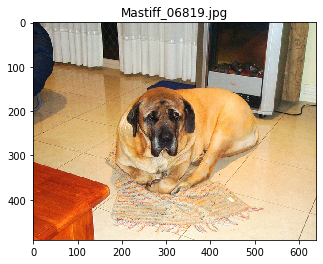

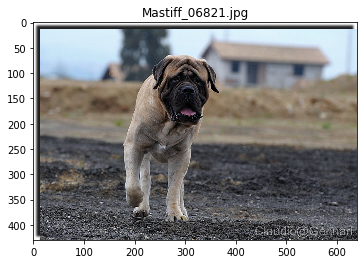

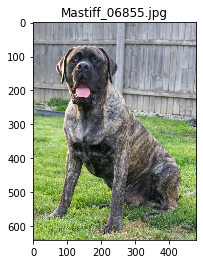

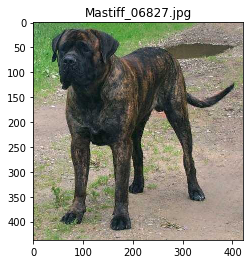

In [25]:
show_image(image_file_directory="dogImages/train/103.Mastiff")
show_image(image_file_path="dogImages/train/103.Mastiff/Mastiff_06821.jpg")

show_image(image_file_directory="dogImages/valid/103.Mastiff")
show_image(image_file_directory="dogImages/test/103.Mastiff")

In [26]:
import pandas as pd
from tqdm import tqdm

def extract_dataset_metadata(dataset_directory: str) -> pd.DataFrame:
    """
    Extract target class, file name, and full file path of the provided dataset directory

    :param dataset_directory: directory where the data are stored
    :type dataset_directory: str
    :return: dataframe that contains metadata: target class, file name, and full file path
    :rtype: pd.DataFrame
    """
    meta = list()
    for directory_name, _, file_names in tqdm(os.walk(dataset_directory)):
        for file_name in file_names:
            class_name = directory_name.split('/')[-1]
            full_path = os.path.join(directory_name, file_name)
            meta.append([
                class_name,
                file_name,
                full_path
            ])
    
    return pd.DataFrame(
        meta, 
        columns=['target_class', 'file_name', 'full_path']
    )

In [27]:
df_meta_train = extract_dataset_metadata(dataset_directory="dogImages/train/")
df_meta_valid = extract_dataset_metadata(dataset_directory="dogImages/valid/")
df_meta_test = extract_dataset_metadata(dataset_directory="dogImages/test/")

134it [00:00, 459.65it/s]
134it [00:00, 529.55it/s]
134it [00:00, 552.31it/s]


In [28]:
df_meta_train["target_class"].value_counts()

005.Alaskan_malamute      77
029.Border_collie         74
015.Basset_hound          73
057.Dalmatian             71
014.Basenji               69
                          ..
128.Smooth_fox_terrier    30
102.Manchester_terrier    29
121.Plott                 28
132.Xoloitzcuintli        26
108.Norwegian_buhund      26
Name: target_class, Length: 133, dtype: int64

In [29]:
df_meta_valid["target_class"].value_counts()

005.Alaskan_malamute                9
015.Basset_hound                    9
029.Border_collie                   9
057.Dalmatian                       9
039.Bull_terrier                    9
                                   ..
119.Petit_basset_griffon_vendeen    4
126.Saint_bernard                   4
132.Xoloitzcuintli                  4
100.Lowchen                         4
128.Smooth_fox_terrier              4
Name: target_class, Length: 133, dtype: int64

In [30]:
df_meta_test["target_class"].value_counts()

015.Basset_hound                   10
005.Alaskan_malamute               10
029.Border_collie                  10
056.Dachshund                       9
039.Bull_terrier                    9
                                   ..
131.Wirehaired_pointing_griffon     3
121.Plott                           3
102.Manchester_terrier              3
108.Norwegian_buhund                3
126.Saint_bernard                   3
Name: target_class, Length: 133, dtype: int64

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a **minimum of two hyperparameters**. However you are encouraged to tune more. You are also encouraged to explain **why** you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [31]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

In [32]:
model_output_dir = 's3://project03-image-classification-vexenta/model/hp-tuning/model.tar.gz'
input_train = f"s3://{BUCKET}/data/train/"
input_valid = f"s3://{BUCKET}/data/valid/"

os.environ["SM_MODEL_DIR"] = model_output_dir
os.environ["SM_CHANNEL_TRAIN"] = input_train
os.environ["SM_CHANNEL_VALIDATION"] = input_valid

In [43]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128]),
    "epochs": CategoricalParameter([10, 15])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: -([0-9\\.]+)"}]

In [45]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="src/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c4.2xlarge",
#     instance_type="ml.m5.xlarge" 
    ## 61% test accuracy on 3 epoch, should pick bigger instances? https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#logsV2:log-groups/log-group/$252Faws$252Fsagemaker$252FTrainingJobs/log-events/pytorch-training-211130-1005-002-1a3d9b0c$252Falgo-1-1638266944
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=2, ## just 2 for testing. can't get best_estimator() if the job is only 1 or 2 hmm
    max_parallel_jobs=2, ## just use 1 for testing
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit(
    inputs={
        "train": input_train, 
        "validation": input_valid,
    },
    wait=True
) # TODO: Remember to include your data channels

....

In [ ]:
tuner.best_training_job()

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

In [ ]:
hyperparameters = best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [ ]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="src/train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
) # TODO: Your estimator here

estimator.fit(wait=True)

In [ ]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

In [ ]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "nll_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()